In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
 
from itertools import product
from tqdm import tqdm_notebook

import Model_Evaluation as me

In [23]:
books = pd.read_csv('/Users/rahulnair/Desktop/Labelmaster_/Sales_Data/Books_ext_fs.csv')
#books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LabelMaster/LabelMaster Data/Books_ext.csv')
sales = books[['Year_Month','Sum of Sales']]
sales['Sum of Sales'] = sales['Sum of Sales']/100000
sales

,Year_Month,Sum of Sales
0,2008-01,2.826041
1,2008-02,2.624744
2,2008-03,3.260597
3,2008-04,2.153875
4,2008-05,4.995599
...,...,...
150,2020-07,1.503481
151,2020-08,1.560669
152,2020-09,4.687110
153,2020-10,11.184468


In [24]:
books = books.dropna(axis = 1)
exog = books.iloc[:,2:]
exog

,"FTR Truck Loadings (000s, SA)_freight_m_trucking","FTR Active Truck Utilization (%, SA)_freight_m_trucking","Reefer Trailer Loadings (000s, SA)_freight_m_trucking","Tank Trailer Loadings (000s, SA)_freight_m_trucking","Chemicals & Allied Products (000s, SA)_freight_m_trucking",Spot TL Rates (w/o FSC)_rates_m_trucking,Total LTL (w/o FSC)_rates_m_trucking,Total LTL (w/ FSC)_rates_m_trucking,Contract TL Tank Rates (w/o FSC)_rates_m_trucking,"OEM Net Orders (U.S. / CAN, units)_indicators_m_trucking",...,BUILD FOR_All_Other,Change in Distillate Fuel Inventories_x,Intermodal Revenue Movements (IANA-ETSO)_Total_x,FTR Intermodal Competitive Index_Intermodal Competitive Index (0=Neutral)_x,U.S. Origin Intermodal Volumes_International_x,Canada Origin Intermodal Volumes_Domestic_x,"N.A. Port Activity, Total TEUs_Exports_x","West Coast Port Activity, Total TEUs_Exports_x","Gulf Coast Port Activity, Total TEUs_Exports_x","Western Canadian Port Activity, Total TEUs_Exports_x"
0,57633.608984,88.294650,3940.638792,6915.782704,3013.868684,96.932289,99.755501,114.408275,99.995901,16185.0,...,969.0,-2981.0,1156094.0,3.341993,557011.0,46969.0,1.035742e+06,428531.270000,90322.590000,70230.000000
1,57175.659828,87.998407,3927.115595,6836.939472,2975.285847,99.719858,99.755501,114.867841,100.276486,11091.0,...,1104.0,-13327.0,1088826.0,2.285576,501961.0,44924.0,1.138045e+06,478707.330000,100410.660000,86567.000000
2,56814.700553,87.790155,3922.853376,6758.129439,2941.079313,103.347853,100.488998,117.070858,99.727612,14647.0,...,1158.0,-9852.0,1082825.0,1.924076,481100.0,46727.0,1.167742e+06,500866.450000,93384.280000,80451.000000
3,56916.813852,89.639867,3978.633479,6858.428982,2906.591249,111.718085,101.589242,122.811123,99.057287,14264.0,...,931.0,-733.0,1158286.0,5.986521,528843.0,53497.0,1.156788e+06,486063.840000,101642.940000,84739.000000
4,56194.246889,89.134818,3990.692209,6804.610846,2872.185063,117.525703,101.314181,123.968232,97.828232,12060.0,...,991.0,6890.0,1184144.0,7.940801,541259.0,53653.0,1.185090e+06,490618.980000,105424.640000,89548.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,61469.059874,89.962431,4379.187334,6571.127779,2639.040651,115.128696,102.231051,113.578198,115.191063,19213.0,...,1359.0,2134.0,1526490.0,-0.192121,513074.0,57503.0,1.095134e+06,393775.832112,125276.157772,103172.000000
151,62140.797176,90.641835,4404.415547,6601.260917,2676.666422,129.107598,104.339853,115.812566,114.911925,18302.0,...,1671.0,1353.0,1575928.0,0.625716,546740.0,56478.0,1.108304e+06,389408.103791,125319.157772,93979.000000
152,62170.174317,90.587889,4381.188114,6556.745680,2600.808117,136.100117,105.898533,117.464895,115.470202,28766.0,...,1711.0,-7196.0,1617044.0,5.475578,557748.0,59269.0,1.099329e+06,386298.700253,117576.128306,103129.000000
153,62870.759335,94.367218,4436.920215,6523.796564,2593.200335,140.122763,106.265281,117.793788,115.098017,36912.0,...,2018.0,-10130.4,1705714.0,9.817290,591616.0,60708.0,1.186353e+06,410614.677268,123604.184721,105255.000000


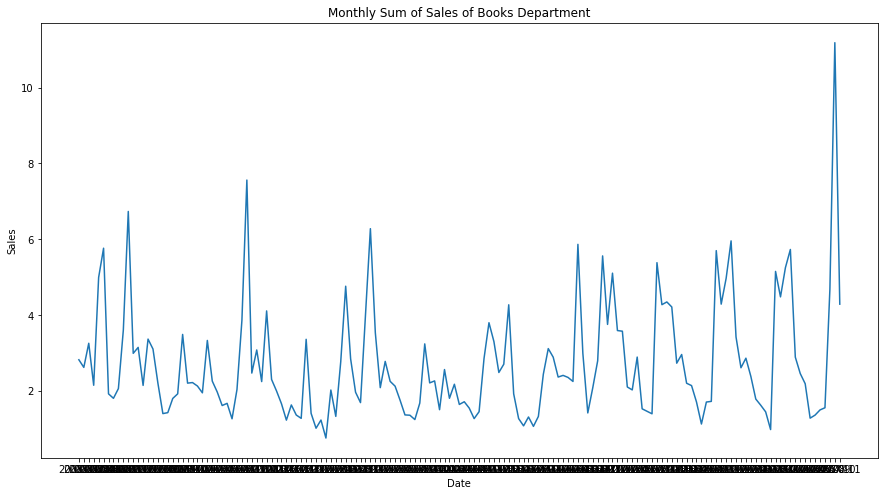

In [25]:
plt.figure(figsize=[15,8])
plt.plot(sales['Year_Month'],sales['Sum of Sales'])
plt.title('Monthly Sum of Sales of Books Department')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [26]:
ad_fuller_result = adfuller(sales['Sum of Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.548908866853434
p-value: 0.10402307648030523


Since the p-value is greater than 0.5, we cannot reject null hypothesis and must assume that the series is not stationary.

In [27]:
sales['sales_diffed'] = sales['Sum of Sales'].diff(1)
sales

,Year_Month,Sum of Sales,sales_diffed
0,2008-01,2.826041,NaN
1,2008-02,2.624744,-0.201297
2,2008-03,3.260597,0.635853
3,2008-04,2.153875,-1.106722
4,2008-05,4.995599,2.841724
...,...,...,...
150,2020-07,1.503481,0.136358
151,2020-08,1.560669,0.057188
152,2020-09,4.687110,3.126440
153,2020-10,11.184468,6.497358


In [7]:
ad_fuller_result = adfuller(sales['sales_diffed'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.7998057140649335
p-value: 4.659551329185685e-07


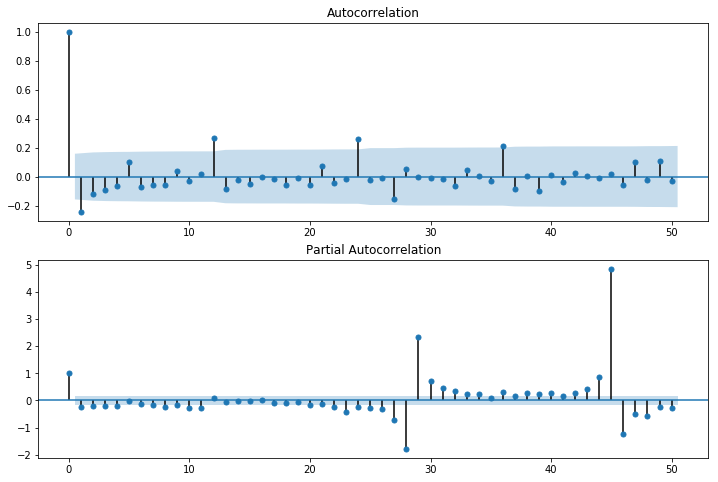

In [8]:
fig, ax = plt.subplots(2,1, figsize= (12,8))
fig = sm.graphics.tsa.plot_acf(sales['sales_diffed'][1:], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(sales['sales_diffed'][1:], lags=50, ax=ax[1])
plt.show()

# New Section

In [28]:
p = range(0,4)
d = range(1,2)
q = range(0,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

df = pd.DataFrame()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales['Sum of Sales'],
                                            exog = exog,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}- AIC:{}'.format(param, param_seasonal, results.aic))

            combo = [(param,param_seasonal,results.aic)]
            df = df.append(combo)
            print(" ")
        except:
            continue
df.columns = ['param','param_seasonal', 'AIC']

ARIMA(0, 1, 0)x(0, 1, 0, 12)- AIC:1127.3043981005615
 
ARIMA(0, 1, 0)x(0, 1, 1, 12)- AIC:539.1242532009969
 
ARIMA(0, 1, 0)x(0, 1, 2, 12)- AIC:499.6023672113552
 
ARIMA(0, 1, 0)x(0, 1, 3, 12)- AIC:4376.531511187808
 
ARIMA(0, 1, 0)x(1, 1, 0, 12)- AIC:541.181773245175
 
ARIMA(0, 1, 0)x(1, 1, 1, 12)- AIC:541.5208471426499
 
ARIMA(0, 1, 0)x(1, 1, 2, 12)- AIC:502.54285633550126
 
ARIMA(0, 1, 0)x(1, 1, 3, 12)- AIC:4468.2349831017
 
ARIMA(0, 1, 0)x(2, 1, 0, 12)- AIC:502.36259514152687
 
ARIMA(0, 1, 0)x(2, 1, 1, 12)- AIC:504.3163194902241
 
ARIMA(0, 1, 0)x(2, 1, 2, 12)- AIC:505.5389704349444
 
ARIMA(0, 1, 0)x(2, 1, 3, 12)- AIC:4232.447733831393
 
ARIMA(0, 1, 0)x(3, 1, 0, 12)- AIC:466.7035070518797
 
ARIMA(0, 1, 0)x(3, 1, 1, 12)- AIC:470.2926073884347
 
ARIMA(0, 1, 0)x(3, 1, 2, 12)- AIC:476.11524670856954
 
ARIMA(0, 1, 0)x(3, 1, 3, 12)- AIC:4337.31106097453
 
ARIMA(0, 1, 1)x(0, 1, 0, 12)- AIC:567.043318898215
 
ARIMA(0, 1, 1)x(0, 1, 1, 12)- AIC:537.7551248225598
 
ARIMA(0, 1, 1)x(0, 1, 2, 12)-

ARIMA(2, 1, 1)x(2, 1, 0, 12)- AIC:502.4921305137831
 
ARIMA(2, 1, 1)x(2, 1, 1, 12)- AIC:504.86260910415194
 
ARIMA(2, 1, 1)x(2, 1, 2, 12)- AIC:508.4899014003205
 
ARIMA(2, 1, 1)x(2, 1, 3, 12)- AIC:4409.469389620639
 
ARIMA(2, 1, 1)x(3, 1, 0, 12)- AIC:467.22723761039094
 
ARIMA(2, 1, 1)x(3, 1, 1, 12)- AIC:470.8514165177588
 
ARIMA(2, 1, 1)x(3, 1, 2, 12)- AIC:475.984645731355
 
ARIMA(2, 1, 1)x(3, 1, 3, 12)- AIC:4369.123575471481
 
ARIMA(2, 1, 2)x(0, 1, 0, 12)- AIC:566.4832864460234
 
ARIMA(2, 1, 2)x(0, 1, 1, 12)- AIC:537.7076594137675
 
ARIMA(2, 1, 2)x(0, 1, 2, 12)- AIC:501.6626701254606
 
ARIMA(2, 1, 2)x(0, 1, 3, 12)- AIC:4919.1104875289075
 
ARIMA(2, 1, 2)x(1, 1, 0, 12)- AIC:540.6244395407621
 
ARIMA(2, 1, 2)x(1, 1, 1, 12)- AIC:540.0325323527089
 
ARIMA(2, 1, 2)x(1, 1, 2, 12)- AIC:505.4366578585297
 
ARIMA(2, 1, 2)x(1, 1, 3, 12)- AIC:4922.825076592459
 
ARIMA(2, 1, 2)x(2, 1, 0, 12)- AIC:503.33635990063567
 
ARIMA(2, 1, 2)x(2, 1, 1, 12)- AIC:506.0316607010131
 
ARIMA(2, 1, 2)x(2, 1, 2, 

In [29]:
df = df.sort_values('AIC').reset_index(drop= True)
df

,param,param_seasonal,AIC
0,"(3, 1, 0)","(3, 1, 0, 12)",464.100705
1,"(2, 1, 0)","(3, 1, 0, 12)",465.323875
2,"(3, 1, 2)","(3, 1, 0, 12)",465.516646
3,"(3, 1, 1)","(3, 1, 0, 12)",466.090829
4,"(1, 1, 0)","(3, 1, 0, 12)",466.474126
...,...,...,...
251,"(2, 1, 2)","(3, 1, 3, 12)",4861.519179
252,"(2, 1, 2)","(2, 1, 3, 12)",4901.456560
253,"(2, 1, 2)","(0, 1, 3, 12)",4919.110488
254,"(2, 1, 2)","(1, 1, 3, 12)",4922.825077


The above output suggests that SARIMAX(3,1,1)(3,1,0,12) yields the lowest AIC value of 2828.563996. Therefore we should consider this to be the optimal option.

In [30]:
mod = sm.tsa.statespace.SARIMAX(sales['Sum of Sales'],
                                exog = exog,
                                order=(3, 1, 1),
                                seasonal_order=(3, 1, 0, 12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Sum of Sales   No. Observations:                  155
Model:             SARIMAX(3, 1, 1)x(3, 1, 0, 12)   Log Likelihood                -212.121
Date:                            Wed, 24 Mar 2021   AIC                            580.242
Time:                                    13:38:04   BIC                            810.796
Sample:                                         0   HQIC                           673.930
                                            - 155                                         
Covariance Type:                              opg                                         
                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

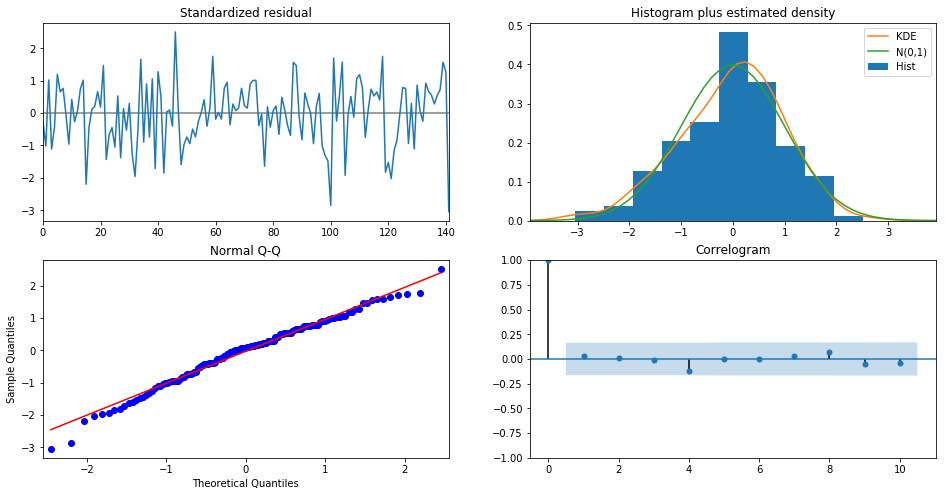

In [31]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Here we will forecast the values using the model. Can change starting point from which we need to forecast. For now we will keep starting point after 50 observations

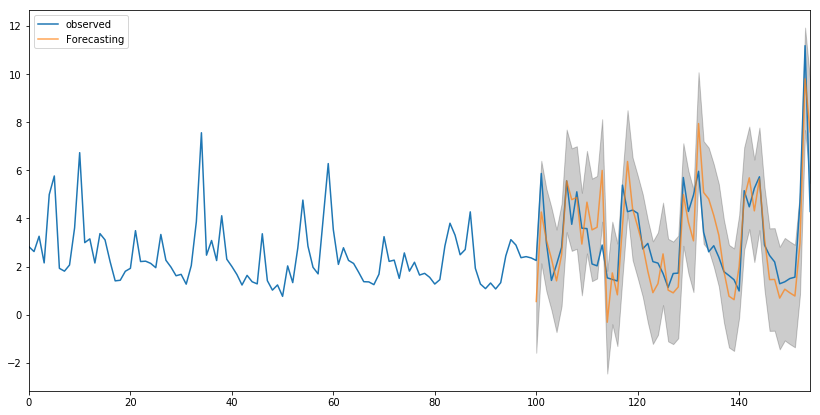

In [32]:
#Point from which prediction starts
start_point = 100
pred = results.get_prediction(start=start_point, dynamic=False)
pred_ci = pred.conf_int()
ax = sales['Sum of Sales'].plot(label='observed',)
pred.predicted_mean.plot(ax=ax, label='Forecasting', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

# Model Evaluation
 - Mean Absolute Percentage Error
 - Mean Absolute Error
 - BIAS
 - Mean Squared Error
 - Root Mean Squared Error

In [ ]:
predictions = pred.predicted_mean
actual = sales['Sum of Sales'][start_point:]

In [38]:
me.evaluate_model(predictions,actual)

			Model Performance

Mean Absolute Percentage Error: 0.371884588540272

Mean Absolute Error: 0.9876081747934955

BIAS: 0.025634388598050912

Mean Squared Error: 0.03614170333377354

Root Mean Squared Error: 0.19010971393848747
